In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#The model
from sklearn.ensemble import IsolationForest

#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings 
warnings.simplefilter("ignore")

### Preprocessing

In [374]:
data=pd.read_csv("/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv")


In [375]:

data=data.copy(deep=True)
data.drop_duplicates(keep="last",inplace=True)
target=data.Class
data=data.drop(["Class","Time"],axis=1)

In [376]:
scaler = MinMaxScaler()
data_scaled_array = scaler.fit_transform(data)

data = pd.DataFrame(data_scaled_array, columns=data.columns)

### Preparation des données d'entraînement et de test

In [377]:
xtrain,xtest,ytrain,ytest=train_test_split(data,target,test_size=0.15,random_state=42,shuffle=True)

#### Concatenation de la xtest et ytest
Cette concatenation à pour objectif de determiner la proportion de données anormaler dans le jeu de données de test (xtest)

In [378]:
xtest.shape

(42559, 29)

In [379]:
concat=pd.concat([xtest.copy(deep=True),ytest.copy(deep=True)],axis=0)

In [380]:
concat.rename(columns={0:"Class"},inplace=True)
concat.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [381]:
concat.Class.value_counts()

Class
0.0    42491
1.0       68
Name: count, dtype: int64

### Définition du modèle

In [382]:
model=IsolationForest(contamination=0.017,bootstrap=False,n_estimators=500,n_jobs=-1,verbose=1)

### Entraînement du modèle

In [383]:
model.fit(xtrain,ytrain)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    1.2s remaining:    8.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    1.2s finished


IsolationForest(contamination=0.017, n_estimators=500, n_jobs=-1, verbose=1)

### Prédiction du modèle

In [384]:
ypred=model.predict(xtest)

### Transformation des targets
ypred return un vecteur contenant que de -1 pour des données anormales et 1 pour les données normales alors que les targets des <br>
des données initial contiennet des 0 pour des données normales et 1 pour des données anormales. Il faut donc transformer ce vecteur <br>
en un vecteur contenant des 1 pour des données normales et -1 pour les anomalies

In [385]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        for i in range(n):
            if target[i]==1:
                target[i]=-1
            elif target.iloc[i]==0:
                target.iloc[i]=1
    elif isinstance(target,pd.DataFrame):
        for i in range(n):
            if target.iloc[i]==1:
                target.iloc[i]=-1
            elif target.iloc[i]==0:
                target.iloc[i]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame):
        for i in range(n):
            if target.iloc[i]==-1:
                target.iloc[i]=1
            elif target[i]==1:
                target.iloc[i]=0

    elif isinstance(target,np.ndarray):
        for i in range(n):
            if target[i]==-1:
                target[i]=1
            elif target[i]==1:
                target[i]=0
    return target

### Evaluation du modèle

In [386]:
def evaluate(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)

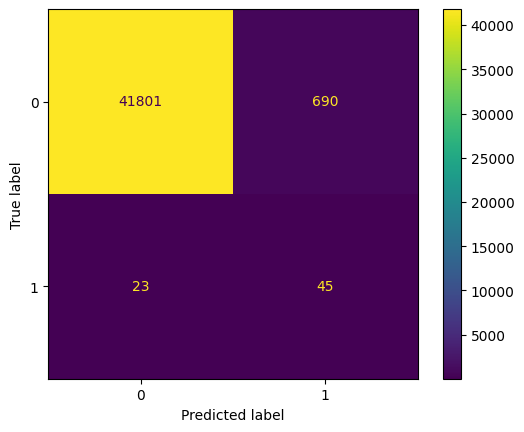

In [387]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.show()

ypred=inverse_transform_target(ypred)
confusin_matrix_display(ytest,ypred)

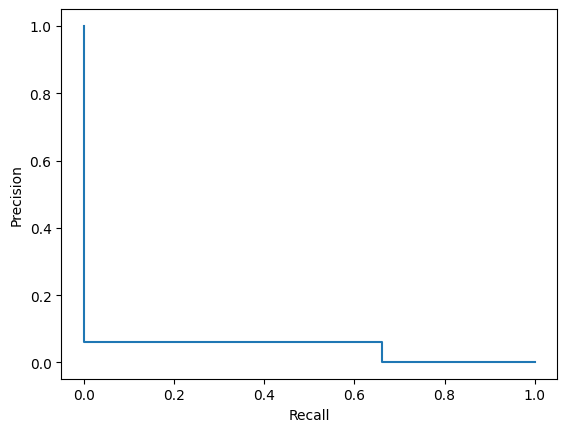

In [388]:
def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.show()

precision_recall_display(ytest, ypred)

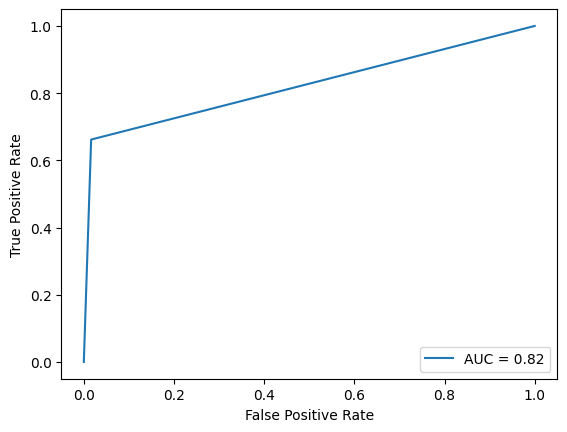

In [389]:
def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
roc_curve_disolay(ytest, ypred)

In [390]:
def scores(ytest,ypred):
    print(f"f1_score\t :{f1_score(ytest,ypred)}")
    print(f"accuracy_score\t :{accuracy_score(ytest,ypred)}")
    print(f"precision_score\t :{precision_score(ytest,ypred)}")
    print(f"recall_score\t :{recall_score(ytest,ypred)}")
scores(ytest,ypred)

f1_score	 :0.11207970112079702
accuracy_score	 :0.9832467868135999
precision_score	 :0.061224489795918366
recall_score	 :0.6617647058823529


### Recherche des hypermaramètres du modèle

In [391]:
parameters={
    "n_estimators":[100,200,300,400,500],
    "contamination":[0.1,0.15,0.175,0.2],
    "max_samples":[0.7,0.8,0.9,1.0],
    "max_features":[0.5,0.6,0.7,0.8,0.9,1.0],
    # "bootstrap":[False,True]
}

In [392]:
scoring_metrics = {
    # 'roc_auc': make_scorer(roc_auc_score),
    'f1_score': make_scorer(f1_score),
    # 'accuracy_score':make_scorer(accuracy_score)
    # 'precision_score':make_scorer(precision_score),
    # 'recall_score':make_scorer(recall_score)
}

In [393]:
gridsearch=GridSearchCV(estimator=IsolationForest(random_state=42),param_grid=parameters,verbose=3,scoring=make_scorer(f1_score), #or scoring_metrics
                        refit=True,cv=3)
gridsearch

GridSearchCV(cv=3, estimator=IsolationForest(random_state=42),
             param_grid={'contamination': [0.1, 0.15, 0.175, 0.2],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'max_samples': [0.7, 0.8, 0.9, 1.0],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring=make_scorer(f1_score), verbose=3)

In [394]:
# ytrain=transform_target(ytrain)
ytrain.value_counts()

Class
0    240762
1       405
Name: count, dtype: int64

In [395]:
ytrain.unique()

array([0, 1])

In [396]:
ytrain=transform_target(ytrain)
ytrain.value_counts()


Class
0    240762
1       405
Name: count, dtype: int64

In [397]:
ytrain.unique()

array([0, 1])

In [398]:
gridsearch.fit(xtrain, ytrain)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[CV 1/3] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100;, score=nan total time=   3.2s
[CV 2/3] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100;, score=nan total time=   3.2s
[CV 3/3] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100;, score=nan total time=   3.2s
[CV 1/3] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=200;, score=nan total time=   6.2s
[CV 2/3] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=200;, score=nan total time=   6.4s


KeyboardInterrupt: 